# Nonlinear model: advertising with diminishing returns
Think of $x$ as advertising spend (or impressions) and $y$ as sales.

We use a saturation model:
$$
E(y\mid x ) =m(x;\theta)=\alpha+\beta\big(1-e^{-\gamma x}\big),\qquad \gamma>0.
$$

Interpretation:
- $\alpha$: baseline sales without advertising  
- $\beta$: long-run lift (plateau is $\alpha+\beta$)  
- $\gamma$: speed of saturation (how fast we approach the plateau)

## Simulate model

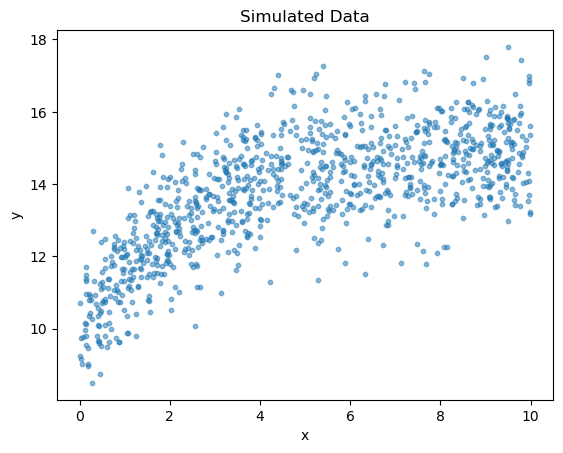

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Model ---
def model(x, theta):
    alpha, beta, gamma = theta
    return alpha + beta * (1.0 - np.exp(-gamma * x))

# True parameters
theta0 = np.array([10.0, 5.0, 0.4])   # alpha, beta, gamma 

# --- Simulate data ---
def simulate_data(N, theta0, sigma=1, rng=None):
    if rng is None:
        rng = np.random
    x = rng.uniform(0.0, 10.0, size=N)
    y = model(x, theta0) + rng.normal(0.0, sigma, size=N)
    return x, y

x, y = simulate_data(N=1000, theta0=theta0, sigma=1.0, rng=None)
plt.scatter(x, y, s=10, alpha=0.5, label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated Data')
plt.show()

## M-estimation (NLS and LAD)

In [13]:
# --- Objective functions ---
# non-linear least squares (NLS) 
def q_nls(theta, model, x, y):
    m = model(x, theta)
    return (y - m)**2

# least absolute deviations (LAD)
def q_lad(theta, model, x, y):
    m = model(x, theta)
    return np.abs(y - m)

# Sample objective functions for NLS and LAD
Q_N_nls = lambda theta: np.mean(q_nls(theta, model, x, y))
Q_N_lad = lambda theta: np.mean(q_lad(theta, model, x, y))

# sensible start values
theta_init = np.array([np.mean(y), (np.max(y)-np.min(y)), 0.1])

# minimize objective functions for NLS and LAD
res_nls = minimize(Q_N_nls, theta_init, method='BFGS')
res_lad = minimize(Q_N_lad, theta_init, method='BFGS')
print("theta0   =", theta0)
print("\nEstimation results (NLS):\n", res_nls)
print("\nEstimation results (LAD):\n", res_lad)


theta0   = [10.   5.   0.4]

Estimation results (NLS):
   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0263349960510186
        x: [ 9.773e+00  5.187e+00  4.315e-01]
      nit: 33
      jac: [ 2.474e-06  1.445e-06  5.424e-06]
 hess_inv: [[ 1.044e+01 -8.048e+00 -1.409e+00]
            [-8.048e+00  8.560e+00  6.008e-01]
            [-1.409e+00  6.008e-01  3.511e-01]]
     nfev: 156
     njev: 39

Estimation results (LAD):
   message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.8037545411139202
        x: [ 9.663e+00  5.281e+00  4.442e-01]
      nit: 45
      jac: [ 1.746e-03  1.218e-03  5.650e-03]
 hess_inv: [[ 9.241e-01 -8.302e-01 -9.218e-02]
            [-8.302e-01  7.551e-01  8.127e-02]
            [-9.218e-02  8.127e-02  9.476e-03]]
     nfev: 806
     njev: 198


## Plot model fit

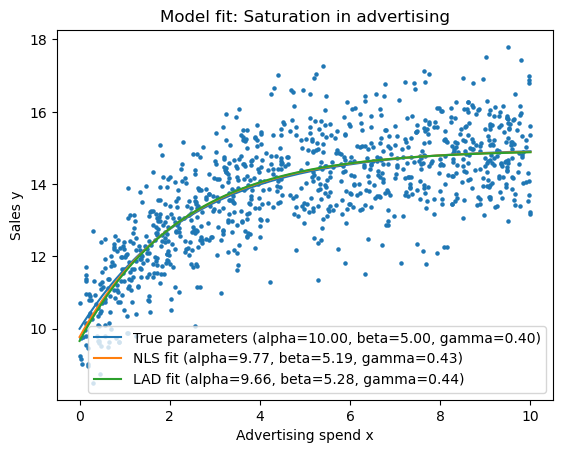

In [14]:
# --- Plot fit ---
def plot_fit(model, theta_hat, legend="", x=None, y=None):
    alpha, beta, gamma = theta_hat
    xx = np.linspace(0, 10, 200)
    if x is not None and y is not None:
        plt.scatter(x, y, s=5)
    plt.plot(xx, model(xx, theta_hat), label=legend + f" (alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f})")
    plt.xlabel("Advertising spend x")
    plt.ylabel("Sales y")
    plt.title('Model fit: Saturation in advertising')

plt.figure()
plot_fit(model, theta0, legend="True parameters", x=x, y=y)
plot_fit(model, res_nls.x, legend="NLS fit")
plot_fit(model, res_lad.x, legend="LAD fit")
plt.legend()
plt.show()

## Plot objective functions for both LAD and NLS for a grid of parameter values 
- keeping alpha and beta fixed at their estimated values


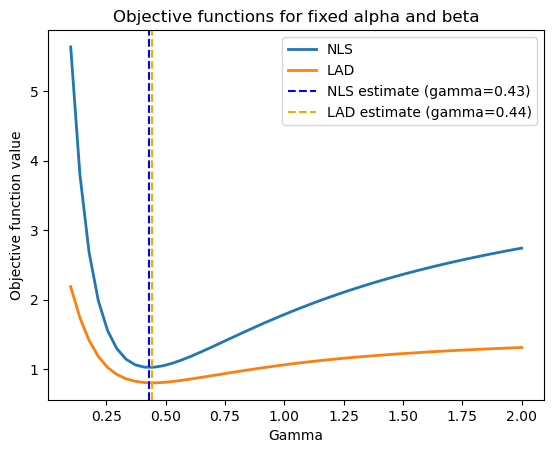

In [ ]:
gamma_grid = np.linspace(0.1, 2, 50)
Q_N_nls_gamma = [Q_N_nls([res_nls.x[0], res_nls.x[1], gamma]) for gamma in gamma_grid]
Q_N_lad_gamma = [Q_N_lad([res_lad.x[0], res_lad.x[1], gamma]) for gamma in gamma_grid]

plt.figure()
plt.plot(gamma_grid, Q_N_nls_gamma, label="NLS", linewidth=2)
plt.plot(gamma_grid, Q_N_lad_gamma, label="LAD", linewidth=2)
# add vertical lines for the estimated gamma values from NLS and LAD
plt.axvline(res_nls.x[2], color='blue', linestyle='--', label=f"NLS estimate (gamma={res_nls.x[2]:.2f})")
plt.axvline(res_lad.x[2], color='orange', linestyle='--', label=f"LAD estimate (gamma={res_lad.x[2]:.2f})")
plt.xlabel("Gamma")
plt.ylabel("Objective function value")
plt.title("Objective functions for fixed alpha and beta")
plt.legend()
plt.show()

## Plot objective as function of gamma and beta holding alpha fixed (add contour lines)

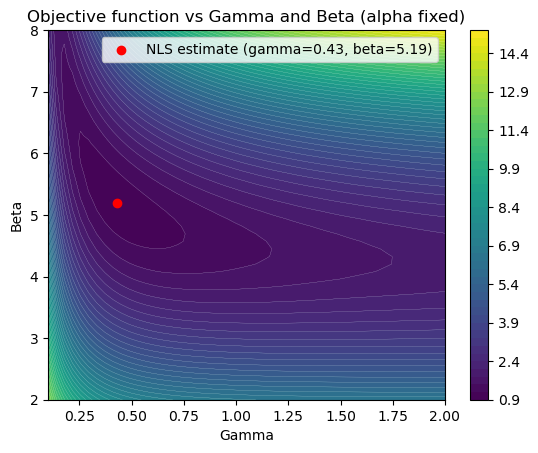

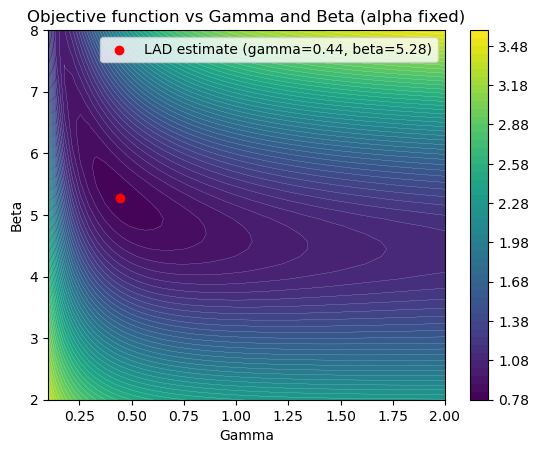

In [26]:
def plot_objective_vs_gamma_beta(model, theta_hat, Q_N, label=""):
    alpha_hat, beta_hat, gamma_hat = theta_hat
    gammas = np.linspace(0.1, 2.0, 50)
    betas = np.linspace(2, 8.0, 50)
    Gamma, Beta = np.meshgrid(gammas, betas)
    Q_values = np.array([[Q_N(np.array([alpha_hat, b, g])) for g in gammas] for b in betas])
    
    plt.figure()
    # add contour plot of objective function with levels, colorbar and contour lines
    cp = plt.contourf(Gamma, Beta, Q_values, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.contour(Gamma, Beta, Q_values, levels=50, colors='white', linewidths=0.1)
    plt.scatter(gamma_hat, beta_hat, color='red', label=label+f" estimate (gamma={gamma_hat:.2f}, beta={beta_hat:.2f})")
    plt.xlabel("Gamma")
    plt.ylabel("Beta")
    plt.title("Objective function vs Gamma and Beta (alpha fixed)")
    plt.legend()
    plt.show()
plot_objective_vs_gamma_beta(model, res_nls.x, Q_N_nls, label="NLS")
plot_objective_vs_gamma_beta(model, res_lad.x, Q_N_lad, label="LAD")



## Monte Carlo 

In [35]:

# histogram of bias across Monte Carlo replications for NLS and LAD
def monte_carlo_bias(N, theta0, sigma=1.0, n_rep=10000):
    bias_nls = []
    bias_lad = []
    for _ in range(n_rep):
        x, y = simulate_data(N, theta0, sigma=sigma)
        res_nls = minimize(lambda th: np.mean(q_nls(th, model, x, y)), theta_init, method='BFGS')
        res_lad = minimize(lambda th: np.mean(q_lad(th, model, x, y)), theta_init, method='BFGS')
        bias_nls.append(res_nls.x - theta0)
        bias_lad.append(res_lad.x - theta0)
    return np.array(bias_nls), np.array(bias_lad)
N_values = [1000]
bias_nls_all = []
bias_lad_all = []
for N in N_values:
    bias_nls, bias_lad = monte_carlo_bias(N, theta0, sigma=1.0, n_rep=1000)
    bias_nls_all.append(bias_nls)
    bias_lad_all.append(bias_lad)





## Plot results

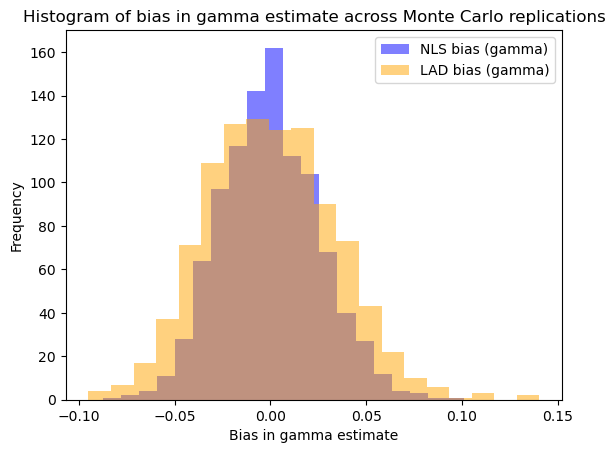

In [36]:
plt.hist(bias_nls_all[0][:, 2], bins=20, alpha=0.5, label="NLS bias (gamma)", color='blue')
plt.hist(bias_lad_all[0][:, 2], bins=20, alpha=0.5, label="LAD bias (gamma)", color='orange')
plt.xlabel("Bias in gamma estimate")
plt.ylabel("Frequency")
plt.title("Histogram of bias in gamma estimate across Monte Carlo replications")
plt.legend()
plt.show()  

## Jax Implementation

In [ ]:
import jax
import jax.numpy as jnp
from jaxopt import BFGS

def Q(theta, x, y):
    alpha, beta, gamma = theta
    m = alpha + beta*(1 - jnp.exp(-gamma*x))
    r = y - m
    return jnp.mean(r**2)

solver = BFGS(fun=lambda th: Q(th, x, y), maxiter=1000, tol=1e-5, verbose=False)
res = solver.run(jnp.array([10.0, 5.0, 0.2]))
theta_hat = res.params
# print results from JAX optimization
print("True values (theta0)   =", theta0)
print("theta_hat=", theta_hat)
print("Q(theta0)   =", Q(theta0, x, y))
print("Q(theta_hat)=", Q(theta_hat, x, y))
print("theta_hat   =", res.params)
print("grad     =\n", res.state.grad)
print("H     =\n", res.state.H)
print("Standard errors=", jnp.sqrt(jnp.diag(jnp.linalg.inv(res.state.H)))  / jnp.sqrt(len(x)) )
